# iTelescope premium image set processing, the hard way

This notebook illustrates how to process a premium image set from iTelescope using the AstroPhotography package. The python environment used corresponds to a miniconda emvironment `ap-env.yml`.

The example dataset used is the iTelescope Plan-20 premium dataset of the M101 supernova [SN 2023 ixf](https://en.wikipedia.org/wiki/SN_2023ixf). Note that these files are not provided with this package. However the notebook should work with your own files if you specify a valid fits-file containing directory at the prompt below.

## Notebook environment setup

In [1]:
import os
import pathlib
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import AstroPhotography as ap

In [2]:
def print_module_version(mod):
    """
    Convenience function to pretty-print Python module mod version.

    Arguments:
        mod {module} -- Imported Python module

    Returns:
        str -- module name and version
    """
    print(f"Using module {mod.__name__} version: {mod.__version__}")
    return

In [3]:
# Get Version information
print(f'Python version: {sys.version}')
print_module_version(np)
print_module_version(matplotlib)
print_module_version(astropy)
print_module_version(ap)

Python version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
Using module numpy version: 1.26.3
Using module matplotlib version: 3.8.2
Using module astropy version: 6.0.0
Using module AstroPhotography version: 0.5.2


In [4]:
# Enable inline plotting for graphics
# %matplotlib inline
# Set default figure size to be larger
# this may only work in matplotlib 2.0+!
from IPython.core.interactiveshell import InteractiveShell
matplotlib.rcParams['figure.figsize'] = [10.0, 6.0]
# Enable multiple outputs from jupyter cells
InteractiveShell.ast_node_interactivity = "all"

## What files do we have to work with?

Let us change the working directory from the location of this notebook to a directory holding some iTelescope premium image set files. In my case this is the Plan-20 M101 dataset.

**Note:** The following processing is fairly low-level and requires a lot of human interaction. In a later section we'll process the same set of files in a more automated way.

In [8]:
print('Enter the path to the directory containing the premium image set')
wdir = input('Image set path:')
os.chdir(wdir)
print('Switched directory to ' + os.getcwd())

Enter the path to the directory containing the premium image set


Image set path: /old_lnx/home/dks/Downloads/iTelescopeScratch/Plan-20-M101SN


Switched directory to /old_lnx/home/dks/Downloads/iTelescopeScratch/Plan-20-M101SN


We now want a pattern that can be used to select the FITS files we want to process, while ignoring any other files or directories we have in that directory (e.g. processed files, configurations files, and so on).

Listing the fits files from the shell I get:
```bash
ls ../Plan-20-M101SN/*fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-2.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-3.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-1.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-2.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-3.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-1.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-2.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-3.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-1.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-2.fits
../Plan-20-M101SN/Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-3.fits
```

So a valid pattern that picks up the original files is `Calibrated-iTelescope*.fits`

In [9]:
default_pattern = 'Calibrated-iTelescope*.fits'
print(f'Default file pattern for input files: {default_pattern}')
msg = 'Enter new input file pattern (or return to accept default pattern)'
file_pattern = input(msg).strip() or default_pattern
print(f'Using "{file_pattern}" as the input file pattern.')

Default file pattern for input files: Calibrated-iTelescope*.fits


Enter new input file pattern (or return to accept default pattern) 


Using "Calibrated-iTelescope*.fits" as the input file pattern.


In [10]:

p_dir = pathlib.Path(r'./')
flist = list(sorted(p_dir.glob(file_pattern)))
print(f'{len(flist)} files match pattern "{file_pattern}" in current directory.')
for fpath in flist:
    print(f'  {fpath.name}')

12 files match pattern "Calibrated-iTelescope*.fits" in current directory.
  Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-2.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-3.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-1.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-2.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Blue-3.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-1.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-2.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Green-3.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-1.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-2.fits
  Calibrated-iTelescope-M101_Supernova_2023ixf-300s-Red-3.fits


### Do these have full headers?

Lets have a look at the FITS header for the first file in this list.

In [11]:
hdr = None
with fits.open(flist[0], mode='readonly') as hdulist:
    print(f'Opened {flist[0].name}')
    hdulist.verify('fix')
    print(hdulist.info())
    hdr = hdulist[0].header
    print(f'Printing the FITS header, length={len(hdr)}')
    hdr

Opened Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
Filename: Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   (3056, 3056)   float32   
None
Printing the FITS header, length=17


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3056                                                  
NAXIS2  =                 3056                                                  
EXTEND  =                    T                                                  
OWNER   = 'iTelescope'                                                          
RA      = '14 03 12.40'        / [hms J2000] Target right ascension             
OBJCTRA = '14 03 12.40'        / [hms J2000] Target right ascension             
DEC     = '+54 20 58.0'        / [dms +N J2000] Target declination              
OBJCTDEC= '+54 20 58.0'        / [dms +N J2000] Target declination              
FOCALLEN=               3962.0 / Focal length of telescope in mm                
APTDIA  =                610

In [12]:
# What keywords do we have (non-comment, non-history)
sorted(list( hdr.keys() ))

['APTDIA',
 'BITPIX',
 'DEC',
 'EXPTIME',
 'EXTEND',
 'FILTER',
 'FOCALLEN',
 'NAXIS',
 'NAXIS1',
 'NAXIS2',
 'OBJCTDEC',
 'OBJCTRA',
 'OBSTARGET',
 'OWNER',
 'RA',
 'SIMPLE',
 'SRCLINK']

Lets look at the keyword differences in more detail

```python
def fkeywords(fname):
    with fits.open(fname) as hdulist:
        hdr=hdulist[0].header
        print(f'FITS header for primary HDU of {fname}')
        print( sorted( list( hdr.keys() ) ) )
    return

f1='Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits'
```

On the M101 files we've been looking at:
```python
fkeywords(f1)
FITS header for primary HDU of Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
['APTDIA', 'BITPIX', 'DEC', 'EXPTIME', 'EXTEND', 'FILTER', 'FOCALLEN', 'NAXIS', 'NAXIS1', 'NAXIS2', 'OBJCTDEC', 'OBJCTRA', 'OBSTARGET', 'OWNER', 'RA', 'SIMPLE', 'SRCLINK']

# iTelescope calibration system
In [17]: f2_itel='calibrated-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fit'

# iTelescope raw file
In [18]: f2_raw='raw-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fit'

# Calibrated file produced by AstroPhotography from the raw file above...
In [19]: f2_apcal='cal-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fits'

In [20]: fkeywords(f2_raw)
FITS header for primary HDU of raw-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fit
['APTAREA', 'APTDIA', 'BITPIX', 'BSCALE', 'BZERO', 'CBLACK', 'CCD-TEMP', 'CSTRETCH', 'CWHITE', 'DATE-OBS', 'EGAIN', 'EXPOSURE', 'EXPTIME', 'FILTER', 'FLIPSTAT', 'FOCALLEN', 'IMAGETYP', 'INSTRUME', 'JD', 'JD-HELIO', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NOTES', 'OBJECT', 'OBSERVER', 'PEDESTAL', 'READOUTM', 'ROWORDER', 'SBSTDVER', 'SET-TEMP', 'SIMPLE', 'SITELAT', 'SITELONG', 'SWCREATE', 'SWOWNER', 'SWSERIAL', 'TELESCOP', 'TRAKTIME', 'XBINNING', 'XORGSUBF', 'XPIXSZ', 'YBINNING', 'YORGSUBF', 'YPIXSZ']

In [21]: fkeywords(f2_itel)
FITS header for primary HDU of calibrated-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fit
['AIRMASS', 'ALT-OBS', 'APTAREA', 'APTDIA', 'BITPIX', 'BSCALE', 'BZERO', 'CALSTAT', 'CBLACK', 'CCD-TEMP', 'CSTRETCH', 'CWHITE', 'DATE', 'DATE-HP', 'DATE-OBS', 'DEC', 'EGAIN', 'EXPOSURE', 'EXPTIME', 'FILTER', 'FLIPSTAT', 'FOCALLEN', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'IMAGETYP', 'INSTRUME', 'JD', 'JD-HELIO', 'LAT-OBS', 'LONG-OBS', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NOTES', 'OBJCTDEC', 'OBJCTRA', 'OBJECT', 'OBSERVAT', 'OBSERVER', 'PEDESTAL', 'PIERSIDE', 'RA', 'RADECSYS', 'READOUTM', 'ROWORDER', 'RollAngle', 'SBSTDVER', 'SET-TEMP', 'SIMPLE', 'SITELAT', 'SITELONG', 'ST', 'SWCREATE', 'SWMODIFY', 'SWOWNER', 'SWSERIAL', 'TELESCOP', 'TIME-OBS', 'TIMESYS', 'TRAKTIME', 'USERNAME', 'UT', 'XBINNING', 'XORGSUBF', 'XPIXSZ', 'YBINNING', 'YORGSUBF', 'YPIXSZ', 'iTelescope', 'iTelescopePlateScaleH', 'iTelescopePlateScaleV']

In [22]: fkeywords(f2_apcal)
FITS header for primary HDU of cal-T05-davestrickland-M82-20210219-002600-Red-BIN1-W-300-001.fits
['AIRMASS', 'ALT-OBS', 'APTAREA', 'APTDIA', 'BIASCORR', 'BIASFILE', 'BITPIX', 'BPIXCORR', 'BPIXDPIX', 'BPIXFILE', 'BPIXNBAD', 'BPIXNFIX', 'BPIXNREM', 'BPIX_MIN', 'BUNIT', 'CBLACK', 'CCD-TEMP', 'CR_CLEAN', 'CR_NPIX', 'CSTRETCH', 'CWHITE', 'DARKCORR', 'DARKFILE', 'DATE-OBS', 'DEC-OBJ', 'EGAIN', 'EXPOSURE', 'EXPTIME', 'FILTER', 'FLATCORR', 'FLATFILE', 'FLIPSTAT', 'FOCALLEN', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'HISTORY', 'IMAGETYP', 'INSTRUME', 'JD', 'JD-HELIO', 'LAT-OBS', 'LON-OBS', 'NAXIS', 'NAXIS1', 'NAXIS2', 'NOTES', 'OBJECT', 'OBJNAME', 'OBSERVAT', 'OBSERVER', 'RA-OBJ', 'READOUTM', 'ROWORDER', 'SBSTDVER', 'SET-TEMP', 'SIMPLE', 'SITELAT', 'SITELONG', 'SWCREATE', 'SWOWNER', 'SWSERIAL', 'TELESCOP', 'TRAKTIME', 'XBINNING', 'XORGSUBF', 'XPIXSZ', 'YBINNING', 'YORGSUBF', 'YPIXSZ']

```

After some rearranging by hand we get the following table of header keywords. The premium file is clearly missing a large number of header keywords, although this doesn't tell us which ones are needed and which ones are superfluous.

|iTelescope raw|iTelescope calibrated|AP calibrated|M101 premium|
|--------------|---------------------|-------------|------------|
|              |AIRMASS              |AIRMASS      |            |
|              |ALT-OBS              |ALT-OBS      |            |
|APTAREA       |APTAREA              |APTAREA      |            |
|APTDIA        |APTDIA               |APTDIA       |APTDIA      |
|              |                     |BIASCORR     |            |
|              |                     |BIASFILE     |            |
|BITPIX        |BITPIX               |BITPIX       |BITPIX      |
|              |                     |BPIXCORR     |            |
|              |                     |BPIXDPIX     |            |
|              |                     |BPIXFILE     |            |
|              |                     |BPIXNBAD     |            |
|              |                     |BPIXNFIX     |            |
|              |                     |BPIXNREM     |            |
|              |                     |BPIX_MIN     |            |
|BSCALE        |BSCALE               |             |            |
|BZERO         |BZERO                |             |            |
|              |                     |BUNIT        |            |
|              |CALSTAT              |             |            |
|CBLACK        |CBLACK               |CBLACK       |            |
|CCD-TEMP      |CCD-TEMP             |CCD-TEMP     |            |
|              |                     |CR_CLEAN     |            |
|              |                     |CR_NPIX      |            |
|CSTRETCH      |CSTRETCH             |CSTRETCH     |            |
|CWHITE        |CWHITE               |CWHITE       |            |
|              |                     |DARKCORR     |            |
|              |                     |DARKFILE     |            |
|              |DATE                 |             |            |
|              |DATE-HP              |             |            |
|DATE-OBS      |DATE-OBS             |DATE-OBS     |            |
|              |DEC                  |             |DEC         |
|              |                     |DEC-OBJ      |            |
|EGAIN         |EGAIN                |EGAIN        |            |
|EXPOSURE      |EXPOSURE             |EXPOSURE     |            |
|EXPTIME       |EXPTIME              |EXPTIME      |EXPTIME     |
|              |                     |             |EXTEND      |
|FILTER        |FILTER               |FILTER       |FILTER      |
|              |                     |FLATCORR     |            |
|              |                     |FLATFILE     |            |
|FLIPSTAT      |FLIPSTAT             |FLIPSTAT     |            |
|FOCALLEN      |FOCALLEN             |FOCALLEN     |FOCALLEN    |
|IMAGETYP      |IMAGETYP             |IMAGETYP     |            |
|INSTRUME      |INSTRUME             |INSTRUME     |            |
|JD            |JD                   |JD           |            |
|JD-HELIO      |JD-HELIO             |JD-HELIO     |            |
|              |LAT-OBS              |LAT-OBS      |            |
|              |LONG-OBS             |LON-OBS      |            |
|NAXIS         |NAXIS                |NAXIS        |NAXIS       |
|NAXIS1        |NAXIS1               |NAXIS1       |NAXIS1      |
|NAXIS2        |NAXIS2               |NAXIS2       |NAXIS2      |
|NOTES         |NOTES                |NOTES        |            |
|              |OBJCTDEC             |             |OBJCTDEC    |
|              |OBJCTRA              |             |OBJCTRA     |
|OBJECT        |OBJECT               |OBJECT       |            |
|              |                     |OBJNAME      |            |
|              |OBSERVAT             |OBSERVAT     |            |
|OBSERVER      |OBSERVER             |OBSERVER     |            |
|              |                     |             |OBSTARGET   |
|              |                     |             |OWNER       |
|PEDESTAL      |PEDESTAL             |             |            |
|              |PIERSIDE             |             |            |
|              |RA                   |             |RA          |
|              |RADECSYS             |             |            |
|              |                     |RA-OBJ       |            |
|READOUTM      |READOUTM             |READOUTM     |            |
|ROWORDER      |ROWORDER             |ROWORDER     |            |
|              |RollAngle            |             |            |
|SBSTDVER      |SBSTDVER             |SBSTDVER     |            |
|SET-TEMP      |SET-TEMP             |SET-TEMP     |            |
|SIMPLE        |SIMPLE               |SIMPLE       |SIMPLE      |
|SITELAT       |SITELAT              |SITELAT      |            |
|SITELONG      |SITELONG             |SITELONG     |            |
|              |                     |             |SRCLINK     |
|              |ST                   |             |            |
|SWCREATE      |SWCREATE             |SWCREATE     |            |
|SWOWNER       |SWMODIFY             |SWOWNER      |            |
|SWSERIAL      |SWOWNER              |SWSERIAL     |            |
|              |SWSERIAL             |             |            |
|TELESCOP      |TELESCOP             |TELESCOP     |            |
|              |TIME-OBS             |             |            |
|              |TIMESYS              |             |            |
|TRAKTIME      |TRAKTIME             |TRAKTIME     |            |
|              |USERNAME             |             |            |
|              |UT                   |             |            |
|XBINNING      |XBINNING             |XBINNING     |            |
|XORGSUBF      |XORGSUBF             |XORGSUBF     |            |
|XPIXSZ        |XPIXSZ               |XPIXSZ       |            |
|YBINNING      |YBINNING             |YBINNING     |            |
|YORGSUBF      |YORGSUBF             |YORGSUBF     |            |
|YPIXSZ        |YPIXSZ               |YPIXSZ       |            |
|              |iTelescope           |             |            |
|              |iTelescopePlateScaleH|             |            |
|              |iTelescopePlateScaleV|             |            |


## Astrometry (aka Navigation)

Combining multiple images of the same source in the same filter requires that each image have a valid World Coordinate System solution, based on an astrometric solution to the stars in the field of view. The `AstroPhotography` package also refers to this process as image navigation. 

The process consists of finding the pixel locations brightest N stars in each image, then calling `Astrometry.net` to compute a WCS solution based on those star locations, and creating a new "navigated" fits file that combines the calibrated file and the WCS solution. By default 2-dimensional Gaussian profiles are also fitted to a representative number of stars per image to assess the Full Width at Half Maximum of the star images (in pixels), the results of which are shown graphically in a plot and numerically in a YaML file describing the stars found and fitted per image. At the end of the process a summary of the image (star) statistics is generated in CSV format that also incorporates the plate scale (arcseconds per pixel) found in the astrometric solution, which allows a human to look for outliers such as images where the seeing or tracking was especially bad.

In terms of pseudo-code
```python
for cal-img in calibrated-images:
    ap_find_stars cal-img --> source-list source-plot fwhm-plot quality-report.yml ds9-sources.reg
    ap_astrometry cal-img source-list --> navigated-img
ap_quality_summary (all quality-report.yml files) --> quality-summary.csv
```
Using the (current but deprecated) bash script `navigate_all.sh` the output for a simple calibrated file is as follows:
```bash
Processing ./20210306/cal-T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits at Sun Feb 11 04:17:23 PM EST 2024
  Cleaning all files...
removed 'SourceLists/srclist_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits'
removed 'SourceLists/implot_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.png'
removed 'SourceLists/ds9_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.reg'
removed 'MetaData/qual_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.yaml'
removed 'MetaData/srclog_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.log'
removed 'NavigatedImages/nav_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits'
  Performing star detection on ./20210306/cal-T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits
    About the run the following command python3 /home/dks/git/AstroPhotography/AstroPhotography/scripts/ap_find_stars.py -l DEBUG -m 200 ./20210306/cal-T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits SourceLists/srclist_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits --retain_saturated --plotfile=SourceLists/implot_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.png --fwhm_plot=SourceLists/fwhmplot_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.png --quality_report=MetaData/qual_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.yaml --ds9=SourceLists/ds9_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.reg
    Star detection completed successfully at Sun Feb 11 04:17:28 PM EST 2024
      Log file written to MetaData/srclog_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.log
  Performing astrometry on ./20210306/cal-T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits
    About the run the following command:  python3 /home/dks/git/AstroPhotography/AstroPhotography/scripts/ap_astrometry.py -l DEBUG ./20210306/cal-T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits SourceLists/srclist_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits NavigatedImages/nav_T05-davestrickland-M81-20210306-235058-B-BIN1-W-300-001.fits
    Astrometry completed successfully at Sun Feb 11 04:17:38 PM EST 2024
```

### Navigating a single image

In [13]:
p_loglevel  = 'DEBUG'                                                     # Loglevel
p_fitsimg   = str(flist[0])                                               # Input fits image
p_extnum    = 0                                                           # Extension number for data in input fits
p_fitstbl   = p_fitsimg.replace('Calibrated-iTelescope', 'srclist')       # Output fits table of srcs
p_search_fwhm       = 3.0                                                 # initial estimate at star fwhm in pixels
p_search_nsigma     = 7.0                                                 # min detection sigma above background
p_detector_bitdepth = 16                                                  # detector bitdepth (16 for most CCDs, ?? for CMOS, ?? for camera)
p_sat_frac          = 0.8                                                 # Fraction of full well at which we assume star saturated
p_max_sources = 200                                                       # Max number of sources to output or None
p_nosatmask   = True                                                      # Keep possibly saturated stars.
p_regfile     = p_fitsimg.replace('Calibrated-iTelescope', 'ds9').replace('fits', 'reg')       # Name of ds9 region file or None
p_plotfile    = p_fitsimg.replace('Calibrated-iTelescope', 'implot').replace('fits', 'png')    # None or name of output png image w sources.
p_qual_rprt   = p_fitsimg.replace('Calibrated-iTelescope', 'qual').replace('fits', 'yaml')     # None or name of output ascii report
p_quiet       = False                                                                          # Quiet mode suppresses STDOUT list printing
p_fwhm_plot   = p_fitsimg.replace('Calibrated-iTelescope', 'fwhmplot').replace('fits', 'png')  # PNG/JPG plot of PSF fits

In [14]:
def find_stars_wrapper(p_loglevel, p_fitsimg, p_fitstbl, 
    p_extnum=0, p_search_fwhm=3.0, p_search_nsigma=7.0,
    p_detector_bitdepth=16, p_sat_frac=0.8, p_max_sources=200,
    p_nosatmask=True, p_plotfile=None, p_quiet=False,
    p_fwhm_plot=None, p_qual_rprt=None, p_regfile=None):
    """
    Wrapper for finding stars using ApFindStars
    """
    
    # Perform initial source detection using default parameters.
    find_stars = ap.ApFindStars(p_fitsimg, p_extnum, p_search_fwhm,
        p_search_nsigma, p_detector_bitdepth, 
        p_max_sources, p_nosatmask, p_sat_frac, p_loglevel,
        p_plotfile, p_quiet)
    
    # Measure 2-Gaussian FWHM for select stars, get average over x and y
    (p_new_fwhm, p_madstd_fwhm, p_npts) = find_stars.measure_fwhm(p_fwhm_plot, 'both')
    
    # Refine source detection
    find_stars.source_search(p_new_fwhm, p_search_nsigma)
    
    # Re-run photometry
    find_stars.aperture_photometry()
    
    # As the source searching and photometry was redone, we should redo
    # the plotting.
    if p_plotfile is not None:
        find_stars.plot_image(p_plotfile)
    
    # Write optional quality report
    if p_qual_rprt is not None:
        find_stars.write_quality_report(p_qual_rprt)

    # Write optional ds9 format region file
    if p_regfile is not None:
        find_stars.write_ds9_region_file(p_regfile)
    
    # Write final sourcelist with photometry.
    find_stars.write_source_list(p_fitstbl)

    return

2024-02-16 20:33:20,505 | AstroPhotography.core.ApFindStars | INFO | Loading extension 0 of FITS file Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits
2024-02-16 20:33:20,506 | AstroPhotography.core.ApFindStars | DEBUG | 2-D BITPIX=-32 image with 3056 columns, 3056 rows
2024-02-16 20:33:20,601 | AstroPhotography.core.ApFindStars | DEBUG | Raw data statistics are min=0.00, max=67450.95, median=491.96
2024-02-16 20:33:21,463 | AstroPhotography.core.ApFindStars | DEBUG | Sigma clipped image stats: mean=492.291, median=491.025, stddev=28.186
2024-02-16 20:33:24,013 | AstroPhotography.core.ApFindStars | DEBUG | Source-masked image stats: mean=489.139, median=488.849, stddev=25.656
2024-02-16 20:33:24,013 | AstroPhotography.core.ApFindStars | DEBUG | Checking for possibly saturated stars or regions.
2024-02-16 20:33:24,013 | AstroPhotography.core.ApFindStars | DEBUG | Looking for possibly saturated regions above 52428 ADU separated by 12 pixels.
2024-02-16 20:33:24,198 | AstroPho

Saturated position table:
 x_peak y_peak peak_value
------ ------ ----------
  2168    134   58007.41
  1861    192  67450.945
   542    301   66776.38
  1733    305    66585.7
   124    785  66806.375
   925    837   65296.09
   978   1256   55520.92
   107   1333   66617.82
   116   1334   66440.46
  3034   1826  65005.867
  2118   2062   65066.12
   244   2213   65891.75
  3026   2245   66356.28
   146   2641  67146.664
  2034   2658  64963.445
  2078   2846  65638.266
  1860   2936  54830.844


2024-02-16 20:33:24,434 | AstroPhotography.core.ApFindStars | INFO | Initial source list using FHWM=3.0 pixels, threshold=7.0 x BG stddev, found 265 sources.
2024-02-16 20:33:24,435 | AstroPhotography.core.ApFindStars | DEBUG | Sources with pixels exceding 52428 ADU will be flagged as possibly saturated.
2024-02-16 20:33:24,435 | AstroPhotography.core.ApFindStars | DEBUG | There are 20 possibly saturated stars in the output source list.
2024-02-16 20:33:24,436 | AstroPhotography.core.ApFindStars | DEBUG | Radius of circular aperture photometry is 6 pixels.
2024-02-16 20:33:24,436 | AstroPhotography.core.ApFindStars | DEBUG | Local BG estimation in annulus outer radius 9 pixels, inner radius 6 pixels.
2024-02-16 20:33:24,480 | AstroPhotography.core.ApFindStars | DEBUG | Image exposure time [seconds]: 180.00
/home/dks/git/AstroPhotography/AstroPhotography/core/ApFindStars.py:420: RuntimeWarning: invalid value encountered in log10
  phot_table['magnitude']   = -2.5 * np.log10(phot_table['

 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky   peak     flux     mag   psbl_sat
--- --------- --------- --------- ---------- ---------- ---- --- -------- -------- ------- --------
  1   1667.02     19.15    0.3604     0.0048     0.0677   25   0   442.41   1.7313 -0.5959    False
  2   2989.30     36.39    0.4067    -0.2695     0.1677   25   0   696.49   2.5255 -1.0059    False
  3   1909.27     67.00    0.4246    -0.1126     0.1653   25   0   403.46   1.4061 -0.3700    False
  4   1554.09     73.38    0.4523     0.0858     0.5413   25   0  1799.92   3.0552 -1.2126    False
  5    153.73     77.81    0.4811    -0.1907    -0.1428   25   0   491.31   1.4794 -0.4252    False
  6   2385.73    102.48    0.4248    -0.4378     0.1723   25   0   409.73   1.4355 -0.3925    False
  7    816.19    111.03    0.9502    -0.0965    -0.0142   25   0  1002.37   4.0108 -1.5081    False
  8   2167.66    134.02    0.4556    -0.1268     0.1220   25   0 57518.56 198.8871 -5.7465     True


2024-02-16 20:33:25,441 | AstroPhotography.core.ApFindStars | INFO | Plotting asinh-stretched bitmap of image and sources to implot-M101_Supernova_2023ixf-180s-Lum-1.png
2024-02-16 20:33:25,444 | ApMeasureStars | DEBUG | Up to 5 stars per sub-region will be fitted, excluding the brightest 0 stars.
2024-02-16 20:33:25,444 | ApMeasureStars | DEBUG | Count based weighting factors will used in fitting?: True
2024-02-16 20:33:25,444 | ApMeasureStars | DEBUG | Will the background level be fitted for?           : True
2024-02-16 20:33:25,446 | ApMeasureStars | INFO | Size of input trimmed source list (filtered): 180
2024-02-16 20:33:25,446 | ApMeasureStars | INFO | Size of full source list used for neighbor removal: 265
2024-02-16 20:33:25,446 | ApMeasureStars | DEBUG | Adopting a fit box width of 18 pixels, edge exclusion of 10 pixels.
2024-02-16 20:33:25,446 | ApMeasureStars | INFO | Preparing to trim the input source list of stars within neighbors within 18 pixels.
2024-02-16 20:33:25,447 

Input table supplied to ApMeasureStars after saturated star filtering:
 id xcenter ycenter peak_adu bgmed_per_pix magnitude
      pix     pix                                   
--- ------- ------- -------- ------------- ---------
 36  988.34  568.25 42082.78        779.98   -9.1844
 49 1717.45  696.67 34665.86        713.27   -8.8793
161 1790.66 1721.07 34437.17        815.72   -8.7501
 43 2376.49  635.89 26131.05        649.73   -8.5449
 53 1958.15  719.35 22915.31        638.96   -8.3771
229 2596.91 2435.92 24442.35        622.76   -8.3455
 35 1742.09  544.99 19561.60        609.22   -8.1980
227 2144.05 2398.49 19322.73        608.14   -8.1614
122 1804.86 1387.08 17871.50        654.15   -8.0227
163 2408.92 1724.56 15033.04        617.66   -7.8377
...     ...     ...      ...           ...       ...
  1 1667.02   19.15   442.41        494.78   -4.1970
 80  700.31 1031.48   315.98        480.95   -4.1920
 69  467.93  915.06  2089.46        488.37   -4.1678
  6 2385.73  102.48   409.73

2024-02-16 20:33:25,648 | ApMeasureStars | DEBUG | Fitting star #20 (id=36) at fixed xpos=9.34, ypos=9.25
2024-02-16 20:33:25,658 | ApMeasureStars | DEBUG | Fitting star #21 (id=50) at fixed xpos=9.33, ypos=9.21
2024-02-16 20:33:25,667 | ApMeasureStars | DEBUG | Fitting star #22 (id=48) at fixed xpos=8.88, ypos=9.01
2024-02-16 20:33:25,677 | ApMeasureStars | DEBUG | Fitting star #23 (id=22) at fixed xpos=9.35, ypos=9.20
2024-02-16 20:33:25,688 | ApMeasureStars | DEBUG | Fitting star #24 (id=58) at fixed xpos=9.36, ypos=8.57
2024-02-16 20:33:25,700 | ApMeasureStars | DEBUG | Fitting completed in 0.238 s (average 9.5 ms/star)
2024-02-16 20:33:25,788 | ApMeasureStars | DEBUG | Estimating median FWHM (direction=both) using 49 FWHM measurements (50 OK fits before clipping).


Fit results:
 id xcenter ycenter peak_adu bgmed_per_pix magnitude nn_dist ... theta_err axrat axrat_err circular fit_ok rchisq
      pix     pix                                            ...                                                 
--- ------- ------- -------- ------------- --------- ------- ... --------- ----- --------- -------- ------ ------
161 1790.66 1721.07 34437.17        815.72   -8.7501  125.45 ...     0.015  1.06      0.00    False   True 192.65
122 1804.86 1387.08 17871.50        654.15   -8.0227   53.17 ...     0.018  1.08      0.00    False   True  44.52
109 1196.95 1314.87 11376.10        564.54   -7.6046  132.69 ...     0.020  1.09      0.00    False   True  13.82
186 1683.85 1972.62  6178.29        579.09   -6.8751  100.60 ...     0.031  1.09      0.01    False   True  11.46
176  868.84 1873.93  5657.47        529.22   -6.8357  196.77 ...     0.025  1.11      0.01    False   True   6.81
263   64.29 2973.19 10470.56        564.72   -7.6378  226.73 ...     0.011 

2024-02-16 20:33:27,037 | ApMeasureStars | INFO | Plotted star FWHM fit cut-outs to fwhmplot-M101_Supernova_2023ixf-180s-Lum-1.png
2024-02-16 20:33:27,038 | ApMeasureStars | DEBUG | Estimating median FWHM (direction=both) using 49 FWHM measurements (50 OK fits before clipping).
2024-02-16 20:33:27,039 | ApMeasureStars | DEBUG | Estimating median FWHM (direction=x) using 25 FWHM measurements (25 OK fits before clipping).
2024-02-16 20:33:27,040 | ApMeasureStars | DEBUG | Estimating median FWHM (direction=y) using 24 FWHM measurements (25 OK fits before clipping).
2024-02-16 20:33:27,040 | AstroPhotography.core.ApFindStars | INFO | Median FWHM (over x and y) is 4.31 +/- 0.34 pixels using 49 data points
2024-02-16 20:33:27,040 | AstroPhotography.core.ApFindStars | DEBUG | Running DAOStarFinder with FWHM=4.31 pixels, threshold=7.0 BG sigma.
2024-02-16 20:33:27,329 | AstroPhotography.core.ApFindStars | INFO | Initial source list using FHWM=4.31242676156308 pixels, threshold=7.0 x BG stddev,

 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky   peak     flux     mag   psbl_sat
--- --------- --------- --------- ---------- ---------- ---- --- -------- -------- ------- --------
  1   1667.04     19.13    0.3563     0.0236     0.0561   25   0   442.41   2.3482 -0.9268    False
  2   2989.28     36.41    0.3944    -0.2044     0.1603   25   0   696.49   3.3373 -1.3085    False
  3    908.27     65.77    0.2993    -0.0374    -0.0883   25   0   315.90   1.5493 -0.4753    False
  4   1909.24     67.00    0.4013    -0.0568     0.1475   25   0   403.46   1.9161 -0.7061    False
  5   1554.09     73.38    0.3961     0.0825     0.5344   25   0  1799.92   4.6817 -1.6760    False
  6    153.72     77.83    0.4333    -0.0941    -0.1353   25   0   491.31   2.0948 -0.8029    False
  7   2385.69    102.40    0.3458    -0.0067     0.0372   25   0   380.84   1.9621 -0.7318    False
  8    816.16    111.02    0.9742    -0.0769    -0.0110   25   0  1002.37   4.1598 -1.5477    False


2024-02-16 20:33:28,332 | AstroPhotography.core.ApFindStars | INFO | Plotting asinh-stretched bitmap of image and sources to implot-M101_Supernova_2023ixf-180s-Lum-1.png
2024-02-16 20:33:28,332 | AstroPhotography.core.ApFindStars | INFO | Image is 3056 cols x 3056 rows
2024-02-16 20:33:28,333 | AstroPhotography.core.ApFindStars | DEBUG | FITS keywords found in image: {'IMG_FILE': ('Calibrated-iTelescope-M101_Supernova_2023ixf-180s-Lum-1.fits', 'Name of image file searched for stars'), 'IMG_COLS': (3056, 'Number of columns in input image'), 'IMG_ROWS': (3056, 'Number of rows in input image'), 'AP_NDET': (306, 'Number of sources detected in the image.'), 'AP_NPHOT': (200, 'Number of sources final photometry.'), 'AP_NFIT': (25, 'Number of sources used in FWHM fitting.'), 'AP_NSIGM': (7.0, 'Source searching threshold (sigma above background)'), 'APTDIA': (610.0, '[mm] Diameter of telescope aperture'), 'RA': ('14 03 12.40', 'Target right ascension'), 'DEC': ('+54 20 58.0', 'Target declinati

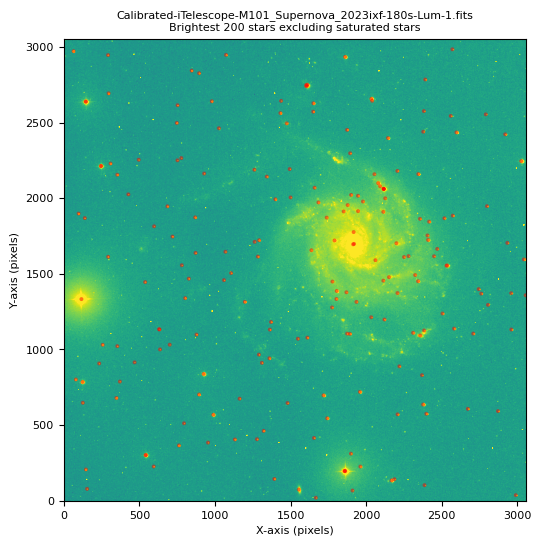

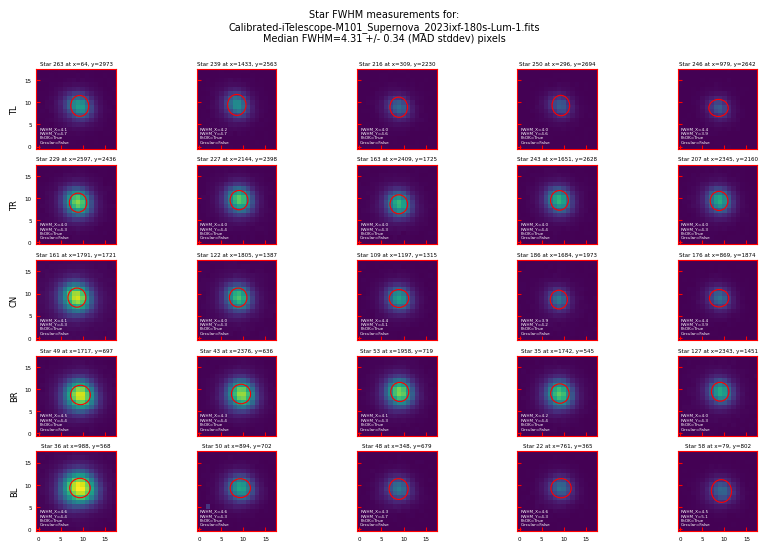

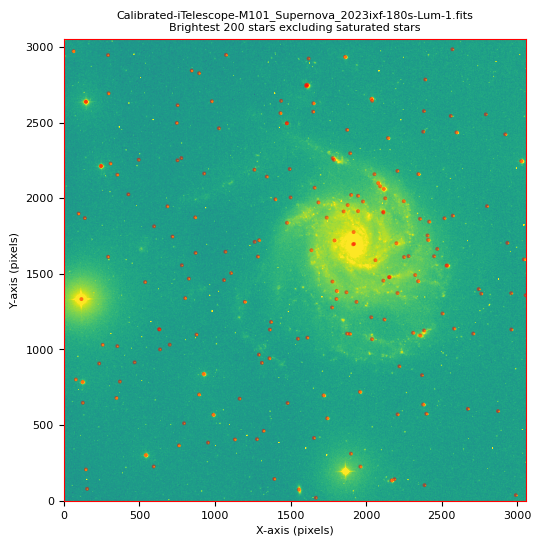

In [15]:
find_stars_wrapper(p_loglevel, p_fitsimg, p_fitstbl, 
    p_extnum, p_search_fwhm, p_search_nsigma,
    p_detector_bitdepth, p_sat_frac, p_max_sources,
    p_nosatmask, p_plotfile, p_quiet,
    p_fwhm_plot, p_qual_rprt, p_regfile)

Rather shockingly this ran without error, despite the limited set of header keywords. The logging did note that "FITS keywords missing from image: ['EXPOSURE', 'DATE-OBS', 'OBJECT', 'OBJNAME', 'TELESCOP', 'INSTRUME', 'CCD-TEMP', 'RA-OBJ', 'DEC-OBJ', 'XPIXSZ', 'YPIXSZ', 'EGAIN', 'LAT-OBS', 'LONG-OBS', 'ALT-OBS', 'AIRMASS']"